# Import Libraries

In [2]:
print('Installing Requirements... ',end='')
!pip install lightning
print('Done')

Installing Requirements... WARNING: Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.HTTPSConnection object at 0x79b73b5cb2b0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /simple/lightning/
ERROR: Could not find a version that satisfies the requirement lightning (from versions: none)
ERROR: No matching distribution found for lightning
Done


In [33]:
!pip install torchsummary

ERROR: Could not find a version that satisfies the requirement torchsummary (from versions: none)
ERROR: No matching distribution found for torchsummary


In [3]:
import math
# Importing Libraries
print('Importing Libraries... ')
import os
from pathlib import Path
# from torchsummary import summary
import soundfile
import pandas as pd
import random
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skms
print('Done')

Importing Libraries... 
Done


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Extract data
with zipfile.ZipFile("/content/drive/MyDrive/Assignment 2/Archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Data Loading and Pre-Processing

In [4]:
# Loading dataset
path = Path('/kaggle/input/environmental-sound-classification-50')
df = pd.read_csv('/kaggle/input/environmental-sound-classification-50/esc50.csv')

In [5]:
df.head(5)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
df[df['esc10']==True]['category'].value_counts()

category
dog               40
chainsaw          40
crackling_fire    40
helicopter        40
rain              40
crying_baby       40
clock_tick        40
sneezing          40
rooster           40
sea_waves         40
Name: count, dtype: int64

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


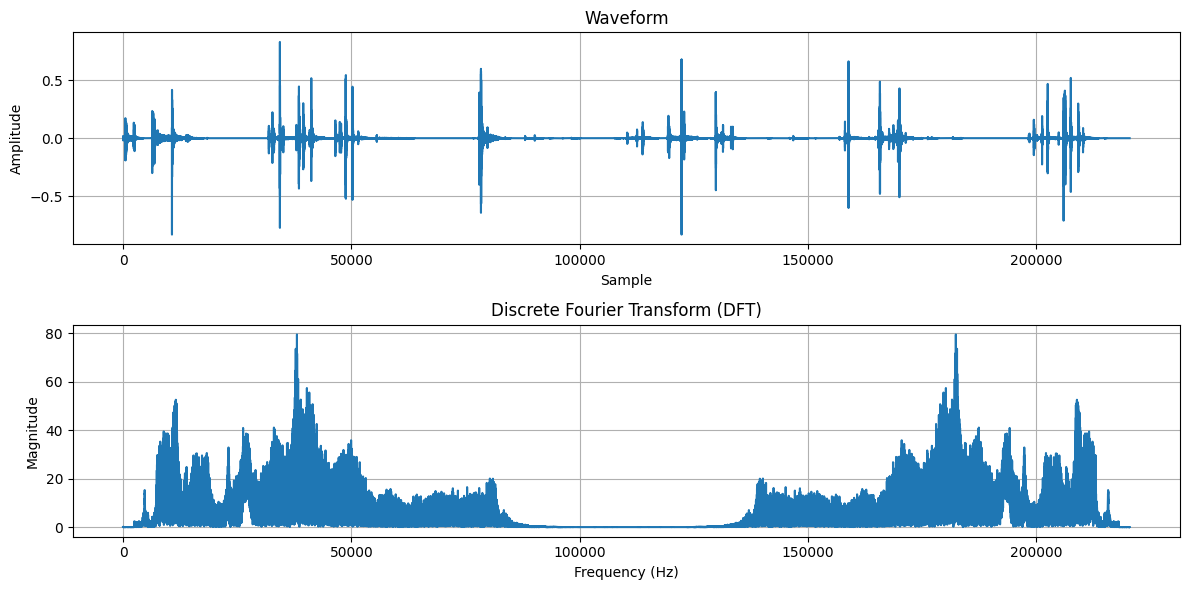

In [8]:
# Getting list of raw audio files
waveform, sample_rate = torchaudio.load(wavs[0])

# Calculate the DFT of the waveform
waveform_f = torch.fft.fft(waveform, dim=1)

# Print the shape of the waveform tensor and the sample rate of the audio file
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

# Plot the waveform and its DFT using matplotlib
plt.figure(figsize=(12, 6))

# Plot the waveform
plt.subplot(2, 1, 1)
plt.plot(waveform.t().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.grid()

# Plot the DFT (magnitude)
plt.subplot(2, 1, 2)
plt.plot(torch.abs(waveform_f).t().numpy())
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Discrete Fourier Transform (DFT)')
plt.grid()

plt.tight_layout()
plt.show()



# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]
        self.training = False
        self.transform = transform
        self.data_transform = transforms.Compose([
                              transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),  # Add Gaussian noise with std=0.1
                              transforms.RandomApply([transforms.Lambda(lambda x: x.flip(1))], p=0.5),  # Randomly flip along the time axis
                              transforms.RandomApply([transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05)], p=0.5),  # Add more Gaussian noise
                              transforms.RandomApply([transforms.Lambda(lambda x: x * torch.rand(1).item() + torch.randn_like(x) * 0.1)], p=0.5),  # Scale and add noise
                              # Add more transforms as needed
                          ])

        self.mfcc = torchaudio.transforms.MFCC()


        if(dataset=='train'):
            self.training = True

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio/audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        # print(path)
        audio_file = torchaudio.load(path, format=None, normalize=True)
        # print(audio_file, audio_file[0])

        audio_tensor = self.resampler(audio_file[0])
        
#         audio_tensor = audio_tensor.to(torch.float32)
#         print(type(audio_tensor), audio_tensor.shape)
        
        dft = torch.fft.fft(audio_tensor, dim=1)
        mfcc = torch.flatten(torch.abs(self.mfcc(audio_tensor)))[:16000]
        mfcc = torch.reshape(mfcc, (1, 16000))
        
#         print(type(mfcc), mfcc.shape, dft.shape)
        
        dft_magnitude = torch.abs(dft)
#         print(type(dft), dft.shape, dft_magnitude.shape)

        # Continue with existing code for splitting audio into frames and returning samples and labels
        splits1 = dft_magnitude.unfold(1, self.window_size, self.step_size)
        splits2 = audio_tensor.unfold(1, self.window_size, self.step_size)
        splits3 = mfcc.unfold(1, self.window_size, self.step_size)
        
        splits = torch.cat((splits1, splits2), dim=1)
        
        samples = splits.permute(1, 0, 2)

        if self.transform and self.training:
            samples = self.data_transform(samples)

        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [10]:
class ConcatenatedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        return len(self.dataset1) + len(self.dataset2)

    def __getitem__(self, index):
        if index < len(self.dataset1):
            return self.dataset1[index]
        else:
            return self.dataset2[index - len(self.dataset1)]

In [11]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset1 = CustomDataset(dataset="train", transform=True,  **self.data_module_kwargs)
            self.training_dataset2 = CustomDataset(dataset="train", transform=True,  **self.data_module_kwargs)
            self.training_dataset = ConcatenatedDataset(self.training_dataset1, self.training_dataset2)
            self.validation_dataset = CustomDataset(dataset="val", transform=False,  **self.data_module_kwargs)

            # print(type(self.training_dataset))

            # print(self.training_dataset[-1])
            # self.training_dataset = self.unfold(self.training_dataset)
            # self.validation_dataset = self.unfold(self.validation_dataset)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", transform=False, **self.data_module_kwargs)

            # self.testing_dataset = self.unfold(self.testing_dataset)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          drop_last=True,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=16,
                          drop_last=True,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          drop_last=True,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        # examples, labels = zip(*data)
        # examples = torch.cat(examples)
        # labels = torch.flatten(torch.tensor(labels))

        # return [examples, labels]
        examples, labels = zip(*data)
        examples = torch.cat(examples)
        examples = examples.view(-1, examples.size(1))  # Flatten the additional dimension
        labels = torch.flatten(torch.tensor(labels))
        return [examples, labels]


In [12]:
# Data Setup
test_samp = 1 #""" Do not change this!! """
valid_samp = 2 # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
batch_size = 32 # Free to change
num_workers = 4 # Free to change
custom_data_module = CustomDataModule(batch_size=batch_size,
                                      num_workers=num_workers,
                                      data_directory=path,
                                      data_frame=df,
                                      validation_fold=valid_samp,
                                      testing_fold=test_samp,  # set to 0 for no test set
                                      esc_10_flag=True,
                                      file_column='filename',
                                      label_column='category',
                                      sampling_rate=44100,
                                      new_sampling_rate=16000,  # new sample rate for input
                                      sample_length_seconds=1  # new length of input in seconds
                                      )

custom_data_module.setup()

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100%|██████████| 80/80 [00:00<00:00, 410.13it/s]


In [13]:
# Data Exploration
print('Class Label: ', custom_data_module.training_dataset[0][1])  # this prints the class label
print('Shape of data sample tensor: ', custom_data_module.training_dataset[0][0].shape)  # this prints the shape of the sample (Frames, Channel, Features)


Class Label:  2
Shape of data sample tensor:  torch.Size([18, 1, 16000])


In [14]:
# Dataloader(s)
x = next(iter(custom_data_module.train_dataloader()))
y = next(iter(custom_data_module.val_dataloader()))
z = next(iter(custom_data_module.test_dataloader()))
print('Train Dataloader:')
print(len(x), x[0].shape)
print('Validation Dataloader:')
print(len(y), y[0].shape)
print('Test Dataloader:')
print(len(z), z[0].shape)


Train Dataloader:
2 torch.Size([9216000, 1])
Validation Dataloader:
2 torch.Size([4608000, 1])
Test Dataloader:
2 torch.Size([9216000, 1])


# **Architecture 1**

In [15]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.CL1 = nn.Sequential(
            # 1d conv filters = 64, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=18, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
        )
        self.CL2 = nn.Sequential(
            # 1d conv filters = 128, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.CL3 = nn.Sequential(
            # 1d conv filters = 256, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            # nn.BatchNorm1d(32),
        )
        self.Cl32 = nn.Sequential(
            # 1d conv filters = 256, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.BatchNorm1d(64),
        )
        self.CL33 = nn.Sequential(
            # 1d conv filters = 256, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.BatchNorm1d(32),
        )
        self.CL4 = nn.Sequential(
            # 1d conv filters = 512, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            # nn.BatchNorm1d(16),
        )
        self.CL5 = nn.Sequential(
            # 1d conv filters = 512, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            # nn.BatchNorm1d(16),
        )

        self.FC1 = nn.Sequential(
            nn.Linear(3104, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.7)
        )

        self.FC2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            # nn.Dropout(0.5)
        )

        # output class = 10
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        x = self.CL1(x)
        x = self.CL2(x)
        x = self.maxpool1(x)
        x = self.CL3(x)
        x = self.Cl32(x)
        x = self.CL33(x)
        # x = self.CL5(x)
        x = x.view(x.size(0), -1)
        x = self.FC1(x)
        x = self.FC2(x)
        return x

In [17]:
model1 = CNNModel()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)

CNNModel(
  (CL1): Sequential(
    (0): Conv1d(18, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (CL2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (CL3): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (Cl32): Sequential(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (CL33): Sequential(
    (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_

Training Loop

Epoch 1/30: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s, accuracy=5.83, loss=4.69]


Validation Accuracy: 2.5 %, Validation Loss: 4.86559944152832


Epoch 2/30: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s, accuracy=16.5, loss=3.92]


Validation Accuracy: 12.5 %, Validation Loss: 4.424977588653564


Epoch 3/30: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s, accuracy=40, loss=2.95]  


Validation Accuracy: 35.0 %, Validation Loss: 3.964960479736328


Epoch 4/30: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s, accuracy=55.8, loss=2.68]


Validation Accuracy: 35.0 %, Validation Loss: 3.5830623149871825


Epoch 5/30: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s, accuracy=64.2, loss=2.38]


Validation Accuracy: 48.75 %, Validation Loss: 3.018527460098267


Epoch 6/30: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s, accuracy=73.1, loss=1.45]


Validation Accuracy: 37.5 %, Validation Loss: 3.1491763591766357


Epoch 7/30: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s, accuracy=72.3, loss=1.76]


Validation Accuracy: 45.0 %, Validation Loss: 3.063725805282593


Epoch 8/30: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s, accuracy=74.4, loss=1.62]


Validation Accuracy: 42.5 %, Validation Loss: 3.030231761932373


Epoch 9/30: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s, accuracy=72.7, loss=1.1] 


Validation Accuracy: 43.75 %, Validation Loss: 2.6802773475646973


Epoch 10/30: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s, accuracy=76.5, loss=0.673]


Validation Accuracy: 42.5 %, Validation Loss: 2.631451416015625


Epoch 11/30: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s, accuracy=81.2, loss=1.51] 


Validation Accuracy: 45.0 %, Validation Loss: 2.916418933868408


Epoch 12/30: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s, accuracy=76.5, loss=0.985]


Validation Accuracy: 47.5 %, Validation Loss: 2.69691481590271


Epoch 13/30: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s, accuracy=81.9, loss=0.77] 


Validation Accuracy: 47.5 %, Validation Loss: 2.623008108139038


Epoch 14/30: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s, accuracy=82.5, loss=0.646]


Validation Accuracy: 43.75 %, Validation Loss: 2.723075342178345


Epoch 15/30: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s, accuracy=82.7, loss=0.825]


Validation Accuracy: 46.25 %, Validation Loss: 2.584873676300049


Epoch 16/30: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s, accuracy=88.3, loss=0.843]


Validation Accuracy: 48.75 %, Validation Loss: 2.467899513244629


Epoch 17/30: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s, accuracy=84.8, loss=0.842]


Validation Accuracy: 45.0 %, Validation Loss: 2.6969437122344972


Epoch 18/30: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s, accuracy=87.3, loss=0.505]


Validation Accuracy: 45.0 %, Validation Loss: 2.510953998565674


Epoch 19/30: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s, accuracy=86.5, loss=0.924]


Validation Accuracy: 50.0 %, Validation Loss: 2.6341877460479735


Epoch 20/30: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s, accuracy=88.5, loss=0.28] 


Validation Accuracy: 38.75 %, Validation Loss: 2.8920359134674074


Epoch 21/30: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s, accuracy=89.4, loss=0.235]


Validation Accuracy: 43.75 %, Validation Loss: 2.601565456390381


Epoch 22/30: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s, accuracy=85.2, loss=0.894]


Validation Accuracy: 46.25 %, Validation Loss: 2.4374294757843016


Epoch 23/30: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s, accuracy=85.4, loss=0.592]


Validation Accuracy: 42.5 %, Validation Loss: 2.7569353580474854


Epoch 24/30: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s, accuracy=85.8, loss=1.42] 


Validation Accuracy: 47.5 %, Validation Loss: 2.8023215770721435


Epoch 25/30: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s, accuracy=88.1, loss=0.512]


Validation Accuracy: 46.25 %, Validation Loss: 2.4619458436965944


Epoch 26/30: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s, accuracy=89.4, loss=0.521]


Validation Accuracy: 46.25 %, Validation Loss: 2.684409475326538


Epoch 27/30: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s, accuracy=87.9, loss=0.234]


Validation Accuracy: 52.5 %, Validation Loss: 2.64403612613678


Epoch 28/30: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s, accuracy=91, loss=0.437]  


Validation Accuracy: 45.0 %, Validation Loss: 2.6226181030273437


Epoch 29/30: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s, accuracy=94, loss=0.204]  


Validation Accuracy: 46.25 %, Validation Loss: 2.5175761699676515


Epoch 30/30: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s, accuracy=91, loss=0.492]  


Validation Accuracy: 48.75 %, Validation Loss: 2.5486804008483888


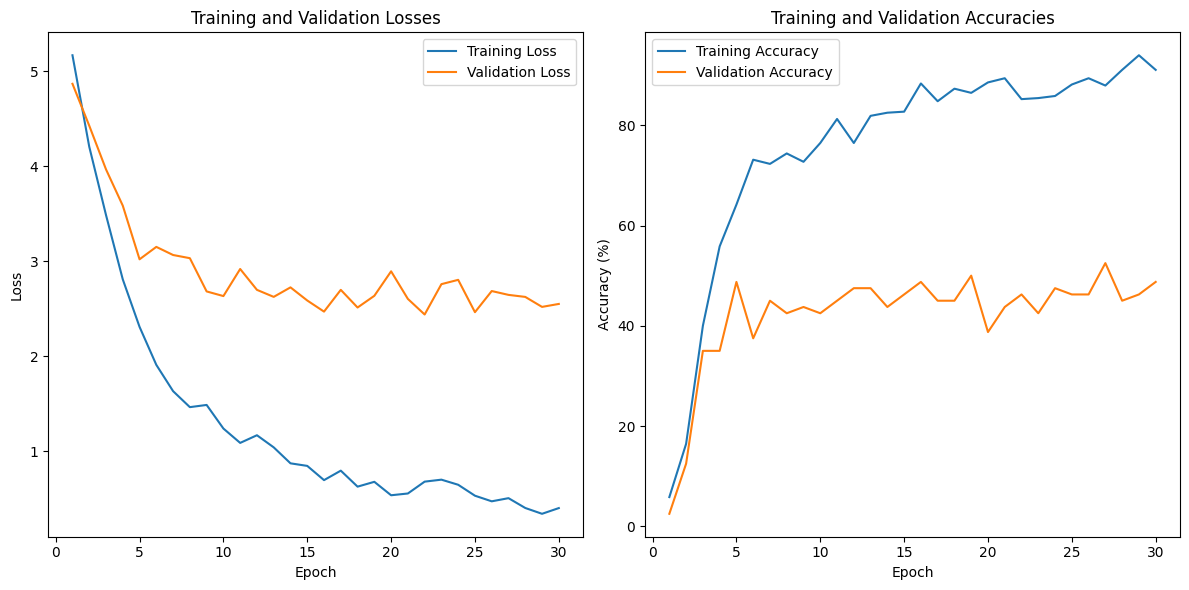

In [18]:
criteria = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

num_epochs = 30
n_total_steps = len(custom_data_module.train_dataloader())

train_losses1 = []
train_accs1 = []
val_losses1 = []
val_accs1 = []

for epoch in range(num_epochs):
    model1.train()
    total = 0
    correct = 0
    train_loss = 0

    with tqdm(total=len(custom_data_module.train_dataloader()), desc=f'Epoch {epoch + 1}/{num_epochs}') as progress_bar:
        for i, (samples, labels) in enumerate(custom_data_module.train_dataloader()):
            samples = samples.to(device)
            labels = labels.to(device)
            samples = samples.reshape(batch_size, 18, -1)

            outputs = model1(samples)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criteria(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
            progress_bar.update()

        train_losses1.append(train_loss / len(custom_data_module.train_dataloader()))
        train_accs1.append(100 * correct / total)

    with torch.no_grad():
        val_loss = 0
        n_correct = 0
        n_samples = 0
        for samples, labels in custom_data_module.val_dataloader():
            samples = samples.to(device)
            labels = labels.to(device)
            samples = samples.view(16, 18, -1)
            outputs = model1(samples)
            predicted = torch.argmax(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            val_loss += criteria(outputs, labels).item()
        val_losses1.append(val_loss / len(custom_data_module.val_dataloader()))
        val_accs1.append(100.0 * n_correct / n_samples)

        acc = 100.0 * n_correct / n_samples
        print(f'Validation Accuracy: {acc} %, Validation Loss: {val_loss / len(custom_data_module.val_dataloader())}')

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs1, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs1, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()


## **4 Fold Cross Validation**

In [172]:
# perform 4 fold cross validation
for i in range(2, 6):
    print('Data Loading')
    custom_data_module = CustomDataModule(batch_size=batch_size,
                                      num_workers=num_workers,
                                      data_directory=path,
                                      data_frame=df,
                                      validation_fold=i,
                                      testing_fold=test_samp,  # set to 0 for no test set
                                      esc_10_flag=True,
                                      file_column='filename',
                                      label_column='category',
                                      sampling_rate=44100,
                                      new_sampling_rate=16000,  # new sample rate for input
                                      sample_length_seconds=1  # new length of input in seconds
                                      )
    
    custom_data_module.setup()
    model1 = CNNModel()
    model1.to(device)
    criteria = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    num_epochs = 100
    n_total_steps = len(custom_data_module.train_dataloader())

    val_acc = 0
    training_acc = 0

    # progress bar for each validation run

    with tqdm(total=num_epochs, desc=f'Validation Fold {i - 1}/{4}') as progress_bar:

        for epoch in range(num_epochs):
            model1.train()
            total = 0
            correct = 0
            
            for i, (samples, labels) in enumerate(custom_data_module.train_dataloader()):
                samples = samples.to(device)
                labels = labels.to(device)
                samples = samples.reshape(batch_size, 18, -1)
                
                # Forward pass
                outputs = model1(samples)
                predicted = torch.argmax(outputs,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criteria(outputs, labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            

            model1.eval()
            # calculate validation accuracy
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for samples, labels in custom_data_module.val_dataloader():
                    samples = samples.to(device)
                    labels = labels.to(device)
                    samples = samples.view(16, 18, -1)
                    outputs = model1(samples)
                    predicted = torch.argmax(outputs, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()
                acc = 100.0 * n_correct / n_samples
                val_acc = val_acc + acc

            progress_bar.set_postfix(epoch=epoch)
            progress_bar.update()
    
    print(f'Validation Accuracy: {acc} %')


Data Loading


Validation Fold 1/4: 100%|██████████| 100/100 [14:16<00:00,  8.57s/it, epoch=99]


Validation Accuracy: 71.25 %
Data Loading


Validation Fold 2/4: 100%|██████████| 100/100 [14:15<00:00,  8.56s/it, epoch=99]


Validation Accuracy: 68.75 %
Data Loading


Validation Fold 3/4: 100%|██████████| 100/100 [14:06<00:00,  8.46s/it, epoch=99]


Validation Accuracy: 62.5 %
Data Loading


Validation Fold 4/4: 100%|██████████| 100/100 [14:05<00:00,  8.45s/it, epoch=99]

Validation Accuracy: 68.75 %


## **Testing**

In [168]:
# Save the model checkpoint
# torch.save(model1.state_dict(), 'model.ckpt')
# print('Model saved')

# Test the model
model1.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for samples, labels in custom_data_module.test_dataloader():
        samples = samples.to(device)
        labels = labels.to(device)
        samples = samples.reshape(32, 18, -1)
        outputs = model1(samples)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test samples: {acc} %')


Accuracy of the network on the test samples: 57.8125 %


Accuracy of the network on the test set: 60.9375 %


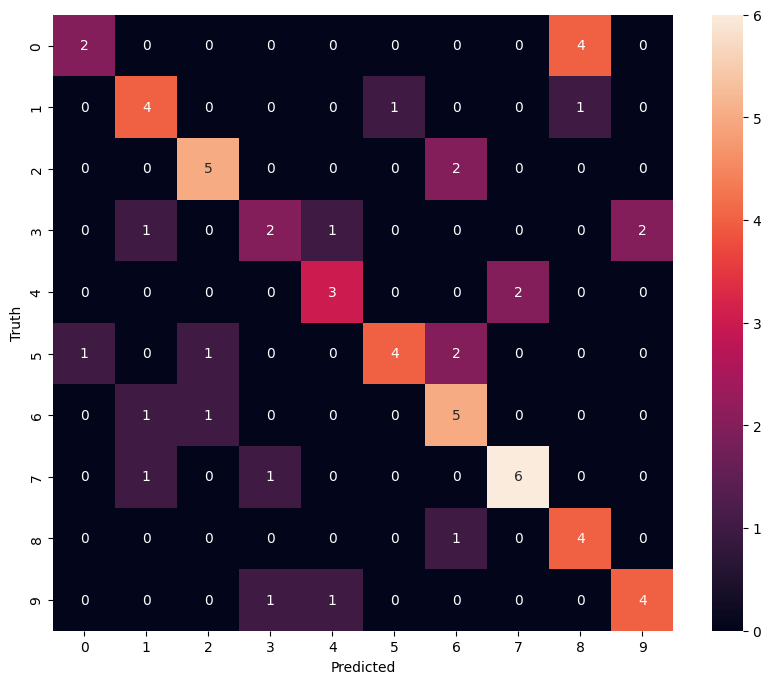

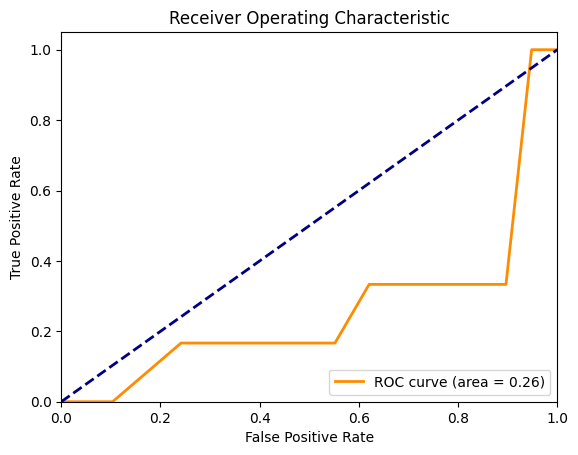

F1 Score: 0.604013143719026


In [20]:
# Save the model checkpoint
# torch.save(model1.state_dict(), 'model.ckpt')   
# print('Model saved')

# Test the model
# Accuracy
# get confusion matrix
# AUC ROC Curve
# F1 Score

model1.eval()
with torch.no_grad():
    n_correct = 0
    y_true = []
    y_pred = []
    n_samples = 0
    for samples, labels in custom_data_module.test_dataloader():
        samples = samples.to(device)
        labels = labels.to(device)
        samples = samples.view(batch_size, 18, -1)
        outputs = model1(samples)
        # max returns (value ,index)
        predicted = torch.argmax(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        y_true.append(labels)
        y_pred.append(predicted)
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test set: {acc} %')

# Confusion Matrix
y_true = torch.cat(y_true).cpu().numpy()
y_pred = torch.cat(y_pred).cpu().numpy()
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# AUC ROC Curve
fpr, tpr, thresholds = skms.roc_curve(y_true, y_pred, pos_label=1)
roc_auc = skms.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# F1 Score
f1 = skms.f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# **Architecture 2**

In [21]:
class CNNBase(nn.Module):
    def __init__(self):
        super(CNNBase, self).__init__()

        self.CL1 = nn.Sequential(
            # 1d conv filters = 64, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=18, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
        )
        self.CL2 = nn.Sequential(
            # 1d conv filters = 128, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.CL3 = nn.Sequential(
            # 1d conv filters = 256, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            # nn.BatchNorm1d(32),
        )
        self.Cl32 = nn.Sequential(
            # 1d conv filters = 256, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.BatchNorm1d(64),
        )
        self.CL33 = nn.Sequential(
            # 1d conv filters = 256, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.BatchNorm1d(32),
        )
        self.CL4 = nn.Sequential(
            # 1d conv filters = 512, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            # nn.BatchNorm1d(16),
        )
        self.CL5 = nn.Sequential(
            # 1d conv filters = 512, kernel_size = 3, stride = 3
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            # nn.BatchNorm1d(16),
        )

        self.FC1 = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.7)
        )

        self.FC2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            # nn.Dropout(0.5)
        )

        # output class = 10
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        x = self.CL1(x)
        x = self.CL2(x)
        x = self.maxpool1(x)
        x = self.CL3(x)
        x = self.Cl32(x)
        x = self.CL33(x)
#         x = self.CL4(x)
        # x = self.CL5(x)
        x = x.view(x.size(0), -1)
        return x

In [22]:
class MHSA(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MHSA, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        # x: (N, L, d_model)
        # print(x.shape)
        a = x.size()
        L, d_model = a[-2], a[-1]
        N = 1
        q = self.W_q(x).view(N, L, self.num_heads, self.depth)
        k = self.W_k(x).view(N, L, self.num_heads, self.depth)
        v = self.W_v(x).view(N, L, self.num_heads, self.depth)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 3, 1)
        v = v.permute(0, 2, 1, 3)
        attn = (q @ k) / np.sqrt(self.depth)
        attn = torch.nn.functional.softmax(attn, dim=-1)
        out = attn @ v
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.view(N, L, d_model)
        out = self.W_o(out)
        return out

In [23]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, embedding_dim]``
        """
        seq_len = x.size(0)
        x = x + self.pe[:, :seq_len]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, d_model, num_heads, num_classes):
        super(TransformerModel, self).__init__()
        
        d_model1 = int(d_model/num_heads)*num_heads
        self.d_model = d_model1
        self.fc0 = nn.Linear(d_model, d_model1)
        self.mhsa1 = MHSA(d_model1, num_heads)
        self.mhsa2 = MHSA(d_model1, num_heads)
        self.pe = PositionalEncoding(d_model1)
        self.fc1 = nn.Linear(d_model1, d_model1)
        self.fc2 = nn.Linear(d_model1, num_classes)
        self.norm1 = nn.LayerNorm(d_model1)
        self.norm2 = nn.LayerNorm(num_classes)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        
        cls_token = torch.zeros(x.size(0), 1).to(x.device)
        x = torch.cat((cls_token, x), dim=1)
        x = self.fc0(x)
#         print(x.shape)
        x = self.pe(x)
#         print(x.shape)
        attn_out = self.mhsa1(x)
        # x = self.norm1(x + self.dropout2(attn_out))
        attn_out = self.mhsa2(attn_out)
        x = x + self.dropout2(attn_out)
        x = self.norm1(x + self.dropout1(self.fc1(x)))
        x = self.norm2(self.dropout1(self.fc2(x)))
        x = self.softmax(x)
        # print(x.shape)
        # reshape x
        x = x.view(-1, 10)
        return x

In [36]:
# create a seq model
# model2  which takes CNNModel output and passes it through the transformer model
model2 = nn.Sequential(
    CNNBase(),
    TransformerModel(3105, 2, 10)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device)

Sequential(
  (0): CNNBase(
    (CL1): Sequential(
      (0): Conv1d(18, 64, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (CL2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,))
      (1): ReLU()
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (CL3): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (Cl32): Sequential(
      (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (CL33): Sequential(
      (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      

Epoch 1/30: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, accuracy=13.3, loss=2.29]


Validation Accuracy: 12.5 %, Validation Loss: 2.2798345565795897


Epoch 2/30: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s, accuracy=35.6, loss=2.25]


Validation Accuracy: 35.0 %, Validation Loss: 2.2293641567230225


Epoch 3/30: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, accuracy=42.5, loss=2.23]


Validation Accuracy: 43.75 %, Validation Loss: 2.2105767250061037


Epoch 4/30: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s, accuracy=52.9, loss=2.22]


Validation Accuracy: 51.25 %, Validation Loss: 2.181516170501709


Epoch 5/30: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s, accuracy=51.9, loss=2.21]


Validation Accuracy: 50.0 %, Validation Loss: 2.1848623752593994


Epoch 6/30: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, accuracy=57.7, loss=2.21]


Validation Accuracy: 47.5 %, Validation Loss: 2.1955013275146484


Epoch 7/30: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, accuracy=60.2, loss=2.18]


Validation Accuracy: 47.5 %, Validation Loss: 2.1763556957244874


Epoch 8/30: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s, accuracy=59, loss=2.17]  


Validation Accuracy: 50.0 %, Validation Loss: 2.1810298919677735


Epoch 9/30: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s, accuracy=63.1, loss=2.21]


Validation Accuracy: 52.5 %, Validation Loss: 2.19079704284668


Epoch 10/30: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, accuracy=60.4, loss=2.18]


Validation Accuracy: 56.25 %, Validation Loss: 2.1479923248291017


Epoch 11/30: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s, accuracy=64, loss=2.18]  


Validation Accuracy: 48.75 %, Validation Loss: 2.1555097103118896


Epoch 12/30: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s, accuracy=65.4, loss=2.16]


Validation Accuracy: 46.25 %, Validation Loss: 2.1713448047637938


Epoch 13/30: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s, accuracy=62.3, loss=2.17]


Validation Accuracy: 47.5 %, Validation Loss: 2.172407531738281


Epoch 14/30: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, accuracy=63.1, loss=2.16]


Validation Accuracy: 53.75 %, Validation Loss: 2.1503807067871095


Epoch 15/30: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, accuracy=66.7, loss=2.16]


Validation Accuracy: 56.25 %, Validation Loss: 2.1621261119842528


Epoch 16/30: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s, accuracy=66.7, loss=2.17]


Validation Accuracy: 52.5 %, Validation Loss: 2.152275276184082


Epoch 17/30: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s, accuracy=65.8, loss=2.14]


Validation Accuracy: 60.0 %, Validation Loss: 2.1734617710113526


Epoch 18/30: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, accuracy=71.2, loss=2.17]


Validation Accuracy: 57.5 %, Validation Loss: 2.1414017200469972


Epoch 19/30: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, accuracy=69.6, loss=2.15]


Validation Accuracy: 57.5 %, Validation Loss: 2.131900691986084


Epoch 20/30: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s, accuracy=69.8, loss=2.15]


Validation Accuracy: 45.0 %, Validation Loss: 2.157584285736084


Epoch 21/30: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s, accuracy=71.7, loss=2.14]


Validation Accuracy: 61.25 %, Validation Loss: 2.1292068481445314


Epoch 22/30: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s, accuracy=71, loss=2.12]  


Validation Accuracy: 51.25 %, Validation Loss: 2.142579364776611


Epoch 23/30: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, accuracy=69.6, loss=2.16]


Validation Accuracy: 55.0 %, Validation Loss: 2.1269737243652345


Epoch 24/30: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, accuracy=66.7, loss=2.14]


Validation Accuracy: 46.25 %, Validation Loss: 2.1656630516052244


Epoch 25/30: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s, accuracy=68.8, loss=2.15]


Validation Accuracy: 47.5 %, Validation Loss: 2.131912851333618


Epoch 26/30: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, accuracy=68.3, loss=2.14]


Validation Accuracy: 43.75 %, Validation Loss: 2.1512707710266112


Epoch 27/30: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, accuracy=69.8, loss=2.11]


Validation Accuracy: 58.75 %, Validation Loss: 2.118907260894775


Epoch 28/30: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, accuracy=72.3, loss=2.12]


Validation Accuracy: 48.75 %, Validation Loss: 2.148227071762085


Epoch 29/30: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s, accuracy=69.6, loss=2.13]


Validation Accuracy: 50.0 %, Validation Loss: 2.119567632675171


Epoch 30/30: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s, accuracy=72.3, loss=2.1] 


Validation Accuracy: 42.5 %, Validation Loss: 2.152392053604126


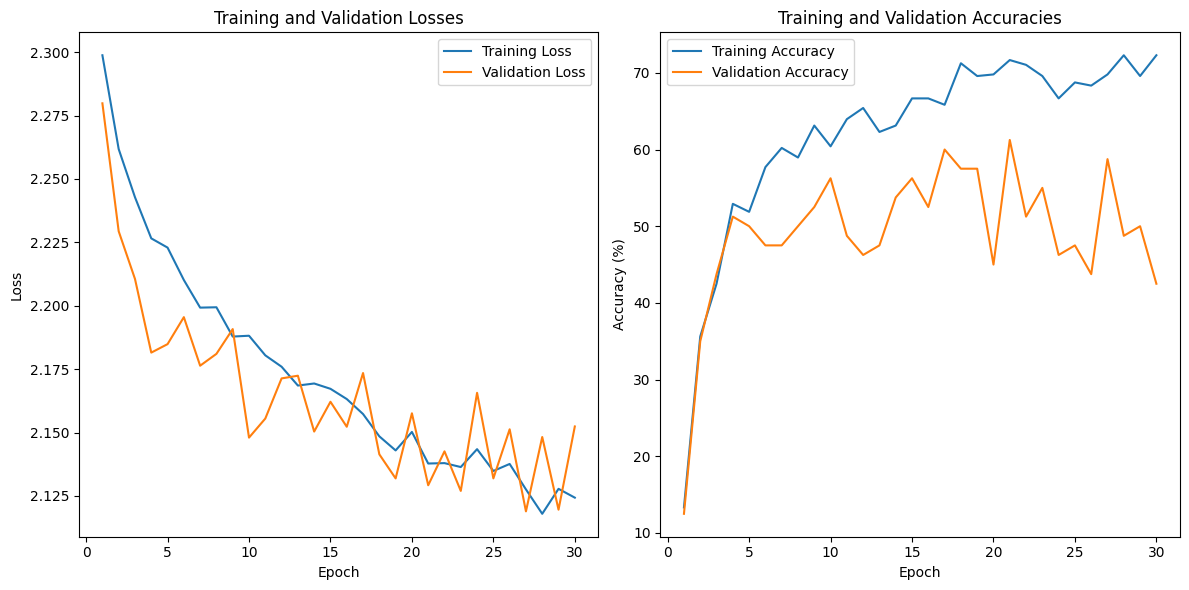

In [37]:
import matplotlib.pyplot as plt

criteria = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
# optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = torch.optim.RMSprop(model2.parameters(), lr=learning_rate, alpha=0.99, eps=1e-8)

num_epochs = 30
n_total_steps = len(custom_data_module.train_dataloader())

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model2.train()
    total = 0
    correct = 0
    train_loss = 0

    with tqdm(total=len(custom_data_module.train_dataloader()), desc=f'Epoch {epoch + 1}/{num_epochs}') as progress_bar:
        for i, (samples, labels) in enumerate(custom_data_module.train_dataloader()):
            samples = samples.to(device)
            labels = labels.to(device)
            samples = samples.reshape(batch_size, 18, -1)

            outputs = model2(samples)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criteria(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
            progress_bar.update()

        train_losses.append(train_loss / len(custom_data_module.train_dataloader()))
        train_accs.append(100 * correct / total)

    with torch.no_grad():
        val_loss = 0
        n_correct = 0
        n_samples = 0
        for samples, labels in custom_data_module.val_dataloader():
            samples = samples.to(device)
            labels = labels.to(device)
            samples = samples.view(16, 18, -1)
            outputs = model2(samples)
            predicted = torch.argmax(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            val_loss += criteria(outputs, labels).item()
        val_losses.append(val_loss / len(custom_data_module.val_dataloader()))
        val_accs.append(100.0 * n_correct / n_samples)

        acc = 100.0 * n_correct / n_samples
        print(f'Validation Accuracy: {acc} %, Validation Loss: {val_loss / len(custom_data_module.val_dataloader())}')

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()


In [34]:
# perform 4 fold cross validation
for i in range(2, 6):
    print('Data Loading')
    custom_data_module = CustomDataModule(batch_size=batch_size,
                                          num_workers=num_workers,
                                          data_directory=path,
                                          data_frame=df,
                                          validation_fold=i,
                                          testing_fold=test_samp,  # set to 0 for no test set
                                          esc_10_flag=True,
                                          file_column='filename',
                                          label_column='category',
                                          sampling_rate=44100,
                                          new_sampling_rate=16000,  # new sample rate for input
                                          sample_length_seconds=1  # new length of input in seconds
                                          )

    custom_data_module.setup()
    model2 = CNNModel()  # Assuming model2 is initialized correctly
    model2.to(device)
    criteria = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    num_epochs = 100
    n_total_steps = len(custom_data_module.train_dataloader())

    val_acc = 0
    training_acc = 0

    # progress bar for each validation run

    with tqdm(total=num_epochs, desc=f'Validation Fold {i - 1}/{4}') as progress_bar:

        for epoch in range(num_epochs):
            model2.train()
            total = 0
            correct = 0

            for i, (samples, labels) in enumerate(custom_data_module.train_dataloader()):
                samples = samples.to(device)
                labels = labels.to(device)
                samples = samples.reshape(batch_size, 18, -1)

                # Forward pass
                outputs = model2(samples)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criteria(outputs, labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            model2.eval()
            # calculate validation accuracy
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for samples, labels in custom_data_module.val_dataloader():
                    samples = samples.to(device)
                    labels = labels.to(device)
                    samples = samples.view(16, 18, -1)
                    outputs = model2(samples)
                    predicted = torch.argmax(outputs, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()
                acc = 100.0 * n_correct / n_samples
                val_acc = val_acc + acc

            progress_bar.set_postfix(epoch=epoch)
            progress_bar.update()

    print(f'Validation Accuracy: {acc} %')

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Data Loading


Validation Fold 1/4: 100%|██████████| 100/100 [12:40<00:00,  7.61s/it, epoch=99]


Validation Accuracy: 72.5 %
Data Loading


Validation Fold 2/4: 100%|██████████| 100/100 [12:41<00:00,  7.61s/it, epoch=99]


Validation Accuracy: 67.5 %
Data Loading


Validation Fold 3/4: 100%|██████████| 100/100 [12:42<00:00,  7.63s/it, epoch=99]


Validation Accuracy: 66.25 %
Data Loading


Validation Fold 4/4: 100%|██████████| 100/100 [12:51<00:00,  7.71s/it, epoch=99]

Validation Accuracy: 72.5 %


**Testing the Model**

Accuracy of the network on the test set: 62.5 %


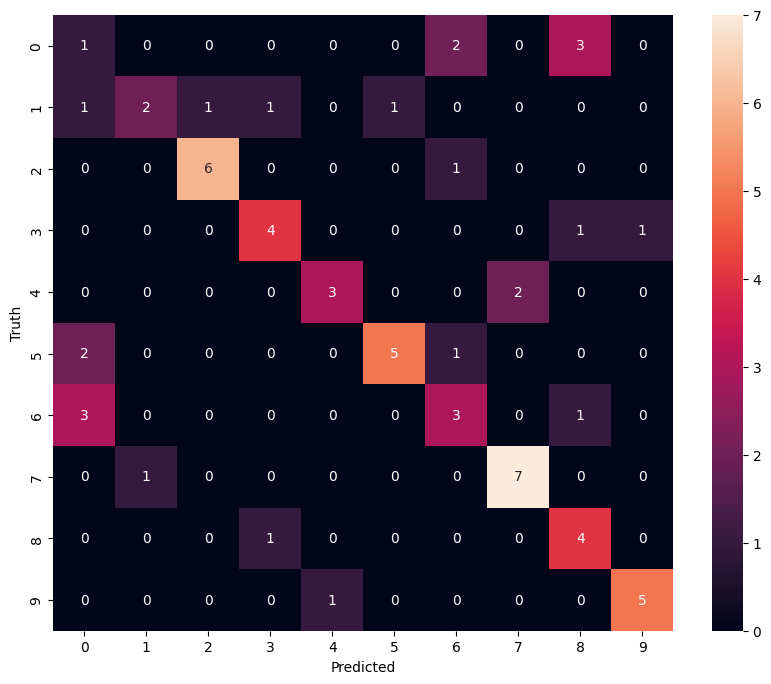

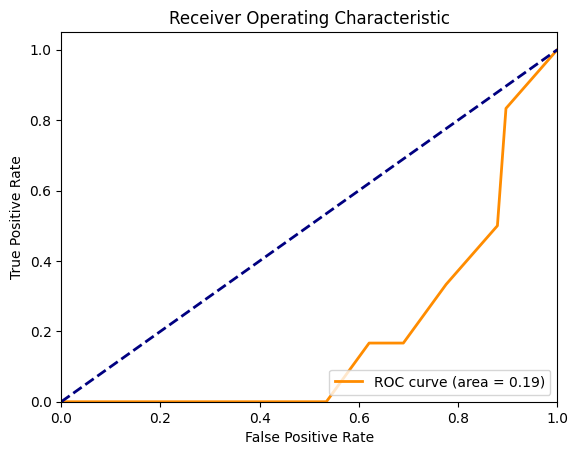

F1 Score: 0.6262928248222366


In [38]:
# Save the model checkpoint
# torch.save(model2.state_dict(), 'model.ckpt')   
# print('Model saved')

# Test the model
# Accuracy
# get confusion matrix
# AUC ROC Curve
# F1 Score

model2.eval()
with torch.no_grad():
    n_correct = 0
    y_true = []
    y_pred = []
    n_samples = 0
    for samples, labels in custom_data_module.test_dataloader():
        samples = samples.to(device)
        labels = labels.to(device)
        samples = samples.view(batch_size, 18, -1)
        outputs = model2(samples)
        # max returns (value ,index)
        predicted = torch.argmax(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        y_true.append(labels)
        y_pred.append(predicted)
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test set: {acc} %')

# Confusion Matrix
y_true = torch.cat(y_true).cpu().numpy()
y_pred = torch.cat(y_pred).cpu().numpy()
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# AUC ROC Curve
fpr, tpr, thresholds = skms.roc_curve(y_true, y_pred, pos_label=1)
roc_auc = skms.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# F1 Score
f1 = skms.f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')
